In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})

from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi,residual

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})
def error(phi_a,phi_n):
    # compute error between analytical and numerical numbers

    return (phi_a-phi_n)/phi_a*100

def convert1D_to_2D(A,N,M):
# Convert phi1D to 2D
    A2D = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            k = (j-1)*N + i
            A2D[i,j]=A[k]

    return A2D

def prepare_phi_and_S(Nx,Ny,phi,L, convert_to_K = False):

    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    if convert_to_K:
        S = np.zeros((Nx*Ny))
    else:   
        S = np.zeros((Nx,Ny))
    dx = L/(Nx-1)    # Grid size
    dy = L/(Ny-1)    # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy
            
            source = 2 * np.sinh(10 * (x - 0.5)) + 40 * (x - 0.5) * np.cosh(10 * (x - 0.5)) + 100 * (
                    x - 0.5) ** 2 * np.sinh(10 * (x - 0.5)) + 2 * np.sinh(10 * (y - 0.5)) + 40 * (
                            y - 0.5) * np.cosh(10 * (y - 0.5)) + 100 * (y - 0.5) ** 2 * np.sinh(
                10 * (y - 0.5)) + 4 * (x ** 2 + y ** 2) * np.exp(2 * x * y)
            
            if convert_to_K:
                k = (j - 1) * Nx + i
                S[k] = source
            else:
                S[i,j] = source

    
    ## Right BC
    i = Nx-1 
    for j in range(1,Ny-1):

        x = i*dx
        y = j*dy
        phiR = 0.25*np.sinh(5)+(y-0.5)**2*np.sinh(10*(y-0.5))+np.exp(2*y)
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i,j] = phiR
            S[i,j] = phiR
        
    ## left BC
    i = 0
    for j in range(1,Ny-1):
        
        x = i*dx
        y = j*dy
        
        phiL = 0.25*np.sinh(-5) + (y-0.5)**2*np.sinh(10*(y-0.5))+1

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i,j] = phiL
            S[i,j] = phiL 

    ## Bottom BC
    j=0
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiB = 0.25*np.sinh(-5) + (x-0.5)**2*np.sinh(10*(x-0.5))+1
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i,j] = phiB
            S[i,j] = phiB
        

    ## Top BC
    j=Ny-1
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiT = 0.25*np.sinh(5)+(x-0.5)**2*np.sinh(10*(x-0.5))+np.exp(2*x)
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i,j] = phiT
            S[i,j] = phiT

    return phi, S


def plot_phi(phi,phi_A,Nx,Ny,method_name,convert=False):

    # If need convert phi from phi[K] to phi[i,j], aka, phi1D to phi2D
    if convert:
        # Analytical solution
        phi2D = np.zeros((Nx,Ny))
        # Convert phi1D to 2D
        for i in range(Nx):
            for j in range(Ny):
                k = (j-1)*Nx+ i
                phi2D[i,j]=phi[k]
        phi = phi2D

    # Plot        
    x,y = np.meshgrid(np.linspace(0,1,Nx),np.linspace(0,1,Ny), indexing='ij')
    fig, ax = plt.subplots(figsize=(14,8))
    CS = ax.contour(x,y,phi, levels=np.arange(-30,30,5))
    ax.clabel(CS, inline=True, fontsize=10)
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')

    ax.set_title('Numerical solution by '+method_name+' iterative solver, code by Congcong Fan')
    fig.tight_layout()

    fig, ax = plt.subplots(figsize=(14,8))
    ax.set_title('Analytical solution, code by Congcong Fan')

    CS = ax.contour(x,y,phi_A, levels=np.arange(-30,30,5))
    ax.clabel(CS, inline=True, fontsize=10)
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')
    fig.tight_layout()

    # Error
    e = error(phi_A,phi)
    fig, ax = plt.subplots(figsize=(14,8))
    CS = ax.contour(e,levels=np.arange(-0.14,0.14,0.02))
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Errors, code by Congcong Fan')
    # make a colorbar for the contour lines
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')
    fig.tight_layout()

def residual(Nx,Ny,phi,S,aE,aW,aN,aS,a0):
    
    R = np.zeros(Nx*Ny)
    R2sum = 0
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):

            k = (j - 1) * Nx + i
            R[k] = S[k] - aE * phi[k + 1] - aW * phi[k - 1] - aN * phi[k + Nx] - aS * phi[k - Nx] - a0 * phi[k]

            R2sum = R2sum + R[k] ** 2
    
    return R2sum, R



In [47]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})
def error(phi_a,phi_n):
    # compute error between analytical and numerical numbers

    return (phi_a-phi_n)/phi_a*100

def convert1D_to_2D(A,N,M):
# Convert phi1D to 2D
    A2D = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            k = (j-1)*N + i
            A2D[i,j]=A[k]

    return A2D

def prepare_phi_and_S(Nx,Ny,phi,L, convert_to_K = False):

    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    if convert_to_K:
        S = np.zeros((Nx*Ny))
    else:   
        S = np.zeros((Nx,Ny))
    dx = L/(Nx-1)    # Grid size
    dy = L/(Ny-1)    # Grid size
    # RHS source terms
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            x = i * dx
            y = j * dy
            k = (j - 1) * Nx + i
            source = 0
            
            if convert_to_K:
                k = (j - 1) * Nx + i
                S[k] = source
            else:
                S[i,j] = source
    
    
    ## Right BC
    i = Nx-1 
    for j in range(1,Ny-1):

        x = i*dx
        y = j*dy
        phiR = 1
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i,j] = phiR
            S[i,j] = phiR
        
    ## left BC
    i = 0
    for j in range(1,Ny-1):
        
        x = i*dx
        y = j*dy
        
        phiL = 0

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i,j] = phiL
            S[i,j] = phiL 

    ## Bottom BC
    j=0
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiB = 0
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i,j] = phiB
            S[i,j] = phiB
        

    ## Top BC
    j=Ny-1
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiT = 1
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i,j] = phiT
            S[i,j] = phiT

    return phi, S


def plot_phi(phi,phi_A,Nx,Ny,method_name,convert=False):

    # If need convert phi from phi[K] to phi[i,j], aka, phi1D to phi2D
    if convert:
        # Analytical solution
        phi2D = np.zeros((Nx,Ny))
        # Convert phi1D to 2D
        for i in range(Nx):
            for j in range(Ny):
                k = (j-1)*Nx+ i
                phi2D[i,j]=phi[k]
        phi = phi2D

    # Plot        
    x,y = np.meshgrid(np.linspace(0,1,Nx),np.linspace(0,1,Ny), indexing='ij')
    fig, ax = plt.subplots(figsize=(14,8))
    CS = ax.contour(x,y,phi)
    ax.clabel(CS, inline=True, fontsize=10)
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')

    ax.set_title('Numerical solution by '+method_name+' iterative solver, code by Congcong Fan')
    fig.tight_layout()

    fig, ax = plt.subplots(figsize=(14,8))
    ax.set_title('Analytical solution, code by Congcong Fan')

    CS = ax.contour(x,y,phi_A)
    ax.clabel(CS, inline=True, fontsize=10)
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')
    fig.tight_layout()

    # Error
    e = error(phi_A,phi)
    fig, ax = plt.subplots(figsize=(14,8))
    CS = ax.contour(e)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Errors, code by Congcong Fan')
    # make a colorbar for the contour lines
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')
    fig.tight_layout()

def residual(Nx,Ny,phi,aE,aW,aN,aS,a0):
    
    R = np.zeros(Nx*Ny)
    R2sum = 0
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            k = (j - 1) * Nx + i
            S = 1 + np.exp(10*phi[k])
            R[k] = -S - aE * phi[k + 1] - aW * phi[k - 1] - aN * phi[k + Nx] - aS * phi[k - Nx] - a0 * phi[k]

            R2sum = R2sum + R[k] ** 2
    
    return R2sum, R



In [62]:
# numbering scheme used is k = (j-1)*N + i
start = time.time()
Nx = 41
Ny = 41
L = 1   # length

S = np.zeros((Nx*Ny))
Q = np.zeros((Nx*Ny))
phi = np.zeros((Nx*Ny))

dx = L/(Nx-1)    # Grid size
dy = L/(Ny-1)    # Grid size

tol = 1e-6
aE = 1/dx**2
aW = 1/dx**2
aN = 1/dy**2
aS = 1/dy**2
a0 = -(2/dx**2 + 2/dy**2)


phi, Q = prepare_phi_and_S(Nx, Ny, phi, L, convert_to_K=True)
S = np.copy(-Q)

R2_old,_ = residual(Nx,Ny,phi,aE,aW,aN,aS,a0)
R2_old = np.sqrt(R2_old)
# for i in range(1,Nx-1):
#         for j in range(1,Ny-1):
#             k = (j - 1) * Nx + i

#             Q[k] = aE * phi[k + 1] + aW * phi[k - 1] + aN * phi[k + Nx] + aS * phi[k - Nx] + a0 * phi[k]
            # S[k] = -Q[k]
for _ in tqdm(range(10000)):

    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            k = (j - 1) * Nx + i

            # Q[k] = aE * phi[k + 1] + aW * phi[k - 1] + aN * phi[k + Nx] + aS * phi[k - Nx] + a0 * phi[k]
            # print(Q[k])
            # S[k] = -Q[k]
            # Source term: 1 + exp(10 * phi[k])
            # Its derivative: 10 * exp(10 * phi[k])
            dqdphi = 10*np.exp(10*phi[k])
            Qpk = dqdphi

            Qck = Q[k] - Qpk * phi[k]

            # Determine whether add scalar to diagonal coefficient terms
            a0 = a0 - np.min([0, Qpk])
            Q[k] = Qck + np.max([0,Qpk]) * phi[k]

            # Gauss-Siedel Update

            phi[k] = (Q[k] - aE*phi[k+1] - aW*phi[k-1] - aN*phi[k+Nx] - aS*phi[k-Nx]) / a0


    # Calculate residual
    R_logger = []
    R2_new,__ = residual(Nx,Ny,phi,aE,aW,aN,aS,a0)
    R2_new = np.sqrt(R2_new)

    if R2_old - R2_new > 100:
        print('De')

        R2_old = R2_new
        continue
    else:
    

        R_logger.append(R2_new)
        if _ %50==0:
            clear_output(True)
            print('Residual:', R2_new)
            
        if R2_new<tol:
            print('Converged! Residual: ',R2_new, 'Time elapsed: ', time.time()-start)
            break


  0%|          | 4/100000 [00:00<46:37, 35.75it/s]/var/folders/q9/8vn_nzj55b55_336zczh1y2c0000gp/T/ipykernel_2264/892727827.py:173: RuntimeWarning: overflow encountered in double_scalars
  R2sum = R2sum + R[k] ** 2
/var/folders/q9/8vn_nzj55b55_336zczh1y2c0000gp/T/ipykernel_2264/683419331.py:81: RuntimeWarning: overflow encountered in multiply
  D0 = D_conjugate + beta* (G + beta*D0)
/var/folders/q9/8vn_nzj55b55_336zczh1y2c0000gp/T/ipykernel_2264/683419331.py:45: RuntimeWarning: invalid value encountered in double_scalars
  ad[k] = E[k]*D0[k] + F[k]*D0[k+1] + H[k]*D0[k+Nx] + D[k]*D0[k-1] + B[k]*D0[k-Nx]
  0%|          | 8/100000 [00:00<47:12, 35.31it/s]

alpha: -0.0003052482320715321
Residual:  6606.71010720092


  0%|          | 26/100000 [00:00<47:33, 35.03it/s]


KeyboardInterrupt: 

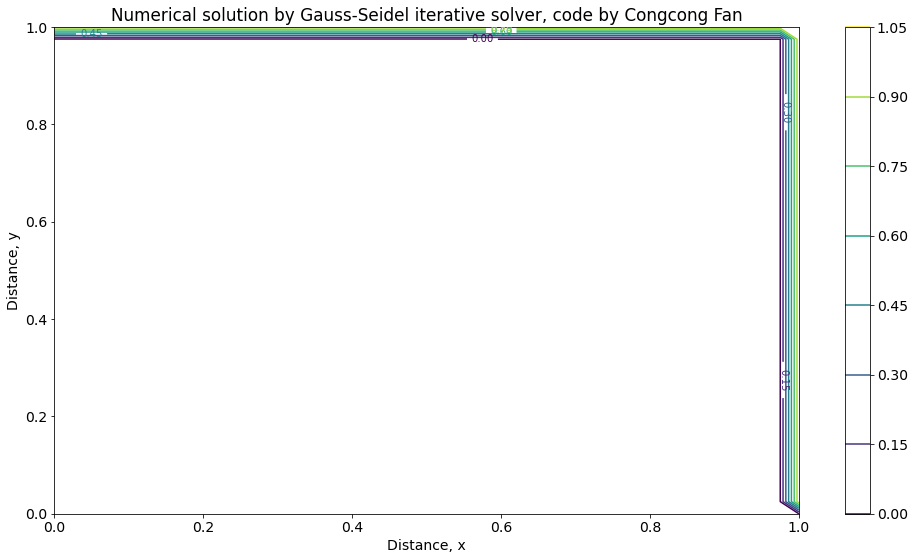

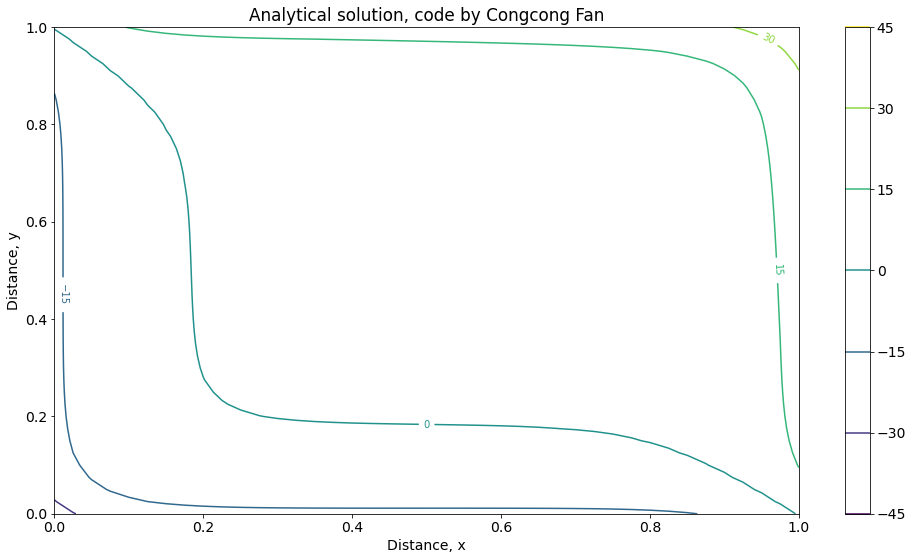

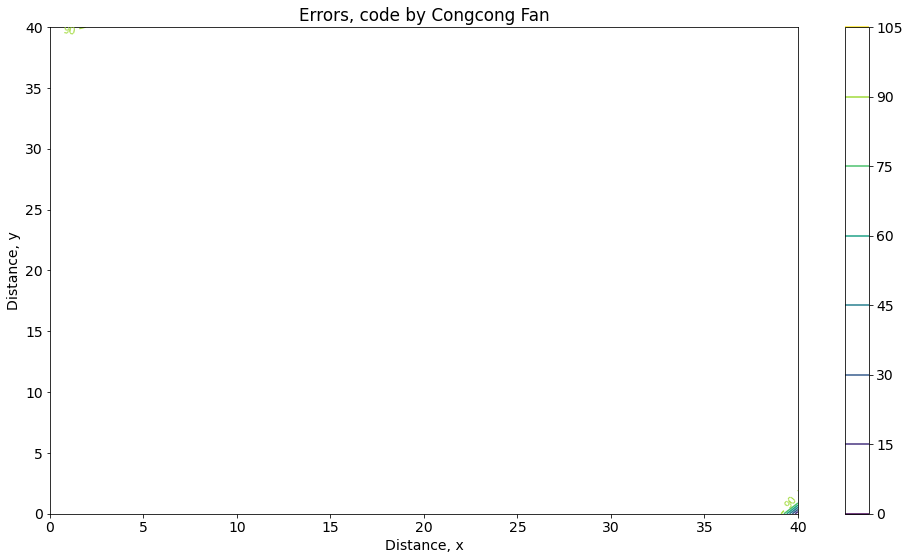

In [56]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, Nx, Ny, 'Gauss-Seidel', convert=True)






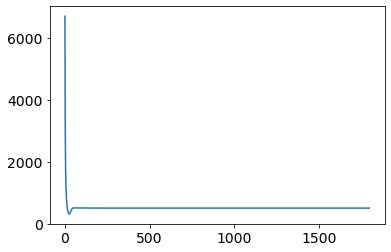

In [ ]:
plt.plot(R)